## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jan  3 11:20:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [3]:
!pip install -q gdown
%cd {HOME}
!gdown '18UPK68fD6sjAbtGH9mHU8DqFkNO1BEe_'

/content
Downloading...
From: https://drive.google.com/uc?id=18UPK68fD6sjAbtGH9mHU8DqFkNO1BEe_
To: /content/video_jalan_kaki.mp4
100% 4.02M/4.02M [00:00<00:00, 112MB/s]


In [4]:
SOURCE_VIDEO_PATH = f"{HOME}/video_jalan_kaki.mp4"

## Install YOLOv8

In [5]:
!pip install ultralytics

from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.232 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## Install Roboflow Supervision

In [6]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.17.1


## Load pre-trained YOLOv8 model

In [7]:
MODEL = "yolov8x.pt"

In [8]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 201MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [9]:
# Kamus memetakan class_id ke class_name
CLASS_NAMES_DICT = model.model.names

# class_id yang diinginkan - person
selected_classes = [0]

In [10]:
import supervision as sv
import numpy as np

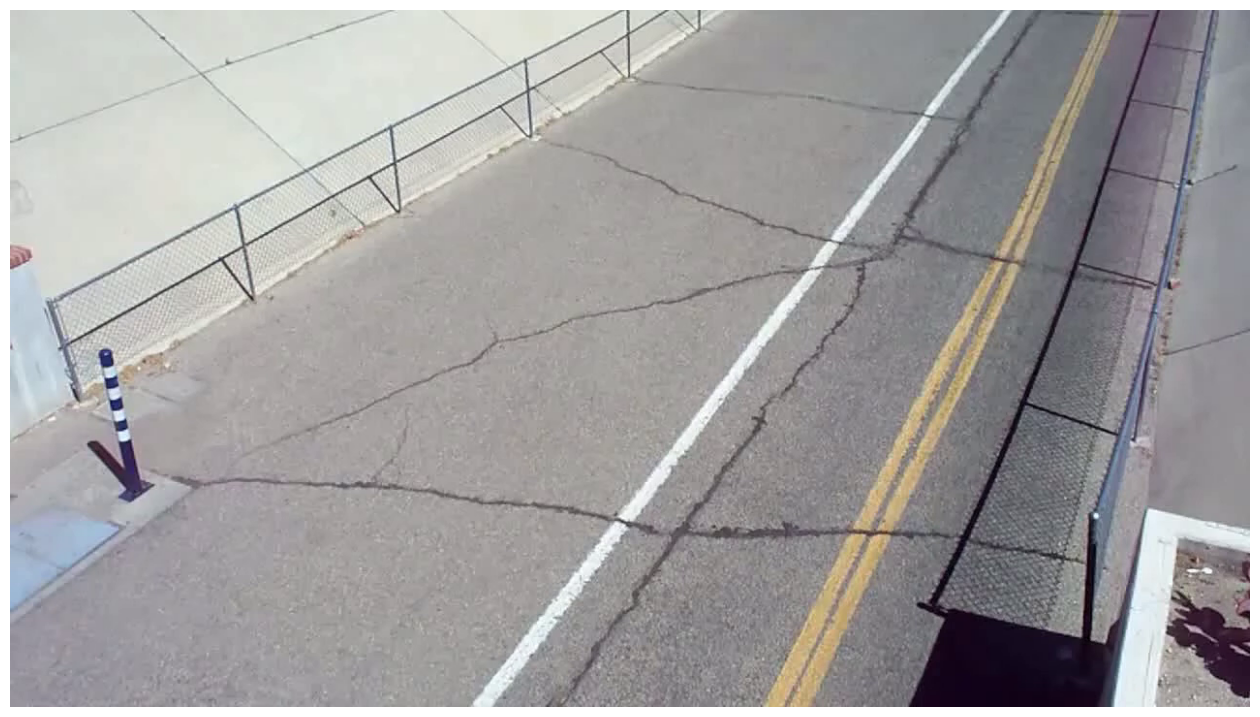

In [11]:
# Membuat generator frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Membuat instance dari BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Mendapatkan frame video pertama
iterator = iter(generator)
frame = next(iterator)

# Prediksi model pada satu frame dan konversi ke Detections format supervision
results = model(frame, verbose=False)[0]

# Konversi ke Detections
detections = sv.Detections.from_ultralytics(results)

# Hanya mempertimbangkan class_id dari selected_classes yang telah didefinisikan sebelumnya
detections = detections[np.isin(detections.class_id, selected_classes)]

# Format label kustom
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]

# Memberi anotasi dan menampilkan frame
annotated_frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Predict and annotate whole video

In [12]:
# Line Settings
LINE_START = sv.Point(1280-50, 360)
LINE_END = sv.Point(50, 360)

TARGET_VIDEO_PATH = f"{HOME}/Result_video.mp4"

In [13]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=24, total_frames=734)

In [14]:
# Membuat instance BYTETracker
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# Membuat instance VideoInfo
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Membuat generator frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Membuat instance LineZone, sebelumnya disebut sebagai kelas LineCounter
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Membuat instance BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Membuat instance TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Membuat instance LineZoneAnnotator, sebelumnya disebut sebagai kelas LineCounterAnnotator
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Mendefinisikan fungsi panggilan kembali yang akan digunakan dalam pemrosesan video
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # Prediksi model pada satu frame dan konversi ke Detections format supervision
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # Hanya mempertimbangkan class_id dari selected_classes yang telah didefinisikan sebelumnya
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # Melacak deteksi
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"   # Labeling
        for _, _, confidence, class_id, tracker_id
        in detections
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels
    )

    # Memperbarui penghitung garis
    line_zone.trigger(detections)
    # Mengembalikan frame dengan hasil anotasi kotak dan garis
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Memproses seluruh video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)